In [37]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold

## Read and format dataset

In [56]:
def get_data():
    # dataset from https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/fruit_data_with_colors.txt
    df = pd.read_csv('fruit.txt', sep='\t')
    # Randomize the order
    df = df.sample(frac=1).reset_index(drop=True)
    target = df["fruit_label"]
    data = df.iloc[:,3:]
    #size = int(df.shape[0] * 0.1)
    size = 10
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = size, random_state = 0)
    #print(f"Training set size: {x_train.shape[0]}, Test set size: {x_test.shape[0]}")
    x_train = np.array(x_train.values)
    x_test = np.array(x_test.values)
    y_train = np.array(y_train.values)
    y_test = np.array(y_test.values)
    return x_train, x_test, y_train, y_test

## Baseline

In [ ]:
df = pd.read_csv('fruit.txt', sep='\t')
print(f"Most common target is {df.fruit_label.mode()[0]} or {df.fruit_label.mode()[1]} (tied)")
print(f"Accuracy of majority guess is {df.fruit_label.value_counts().max()} / {df.shape[0]} = {df.fruit_label.value_counts().max() / df.shape[0]}")
colors = ["red","orange", "darkorange","yellow"]
plt.bar(df.fruit_name.unique(), np.array(df.groupby('fruit_name').size()),color= colors)

## Machine Learning algorithms as modular units

In [39]:
# Logistic regression
def run_log_reg(C, max_iterations, x_train, y_train, x_val, y_val):
    log_reg = LogisticRegression(solver="lbfgs", max_iter=max_iterations, multi_class="auto", C = C)
    log_reg.fit(x_train, y_train)
    train_score = log_reg.score(x_train, y_train)
    val_score = log_reg.score(x_val, y_val)
    return train_score, val_score

In [40]:
# SVM max margin classification
def run_svc(C, gamma, x_train, y_train, x_val, y_val):
    clf = svm.SVC(gamma=gamma, C = C)#kernel='poly',degree = 3, gamma='scale')
    clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    val_score = clf.score(x_val, y_val)
    return train_score, val_score

In [41]:
# Decision Tree
def run_tree(max_depth, x_train, y_train, x_val, y_val):
    clf = tree.DecisionTreeClassifier(splitter="random", max_depth=max_depth)
    clf = clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    val_score = clf.score(x_val, y_val)
    tree.plot_tree(clf)
    return train_score, val_score

## Hyperparameter tuning functions

0.7555555555555555 0.8
Best C: 0.8
Best validation performance: 0.74
Test performance: 0.8


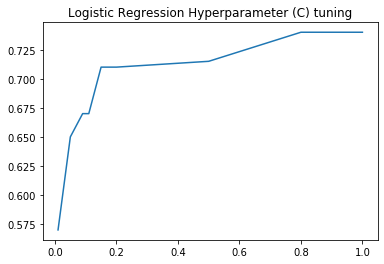

(0.74, 0.8, 0.8)

In [57]:
def tune_log_reg(verbose=False):
    # Hyperparameter Tuning
    x_rest, x_test, y_rest, y_test = get_data()
    Cs = [0.01, 0.01, 0.05, 0.09, 0.1, 0.11, 0.15, 0.2, 0.5, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
    max_iters_tuning = [10000]
    train_scores = []
    val_scores = []
    max_train = 0
    max_val = 0
    best_C = 0
    best_iters = 0
    splits = 10
    for C in Cs:
        for max_iters in max_iters_tuning:
            kf = KFold(n_splits=splits)
            kf.get_n_splits(x_rest)
            split_train_scores = []
            split_val_scores = []
            for train_index, val_index in kf.split(x_rest):
                x_train, x_val = x_rest[train_index], x_rest[val_index]
                y_train, y_val = y_rest[train_index], y_rest[val_index]
                train_score, val_score = run_log_reg(C, max_iters, x_train, y_train, x_val, y_val)
                split_train_scores.append(train_score)
                split_val_scores.append(val_score)
            train_score = sum(split_train_scores) / len(split_train_scores)
            val_score = sum(split_val_scores) / len(split_val_scores)
            train_scores.append(train_score)
            val_scores.append(val_score)
            if val_score > max_val:
                best_C = C
                best_iters = max_iters
                max_val = val_score

    train_score, test_score = run_log_reg(best_C, best_iters, x_train, y_train, x_test, y_test)
    if verbose:
        print(train_score, test_score)
        print(f"Best C: {best_C}")
        print(f"Best validation performance: {max_val}")
        print(f"Test performance: {test_score}")
        plt.plot(Cs, val_scores)
        plt.title("Logistic Regression Hyperparameter (C) tuning")
        plt.show()
    return max_val, test_score, best_C
tune_log_reg(verbose=True)

In [54]:
def tune_svc(verbose=False):
    # Hyperparameter Tuning
    x_rest, x_test, y_rest, y_test = get_data()

    gammas = [0.1, 0.2, 0.5, 0.9, 1]
    #gammas = [0.2]
    Cs = [0.01, 0.01, 0.05, 0.09, 0.1, 0.11, 0.15, 0.2, 0.5, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
    #Cs = [0.95]
    train_scores = []
    val_scores = []
    max_train = 0
    max_val = 0
    best_C = 0
    best_gamma = 0
    splits = 10
    for gamma in gammas:
        for C in Cs:
            kf = KFold(n_splits=splits)
            kf.get_n_splits(x_rest)
            split_train_scores = []
            split_val_scores = []
            for train_index, val_index in kf.split(x_rest):
                x_train, x_val = x_rest[train_index], x_rest[val_index]
                y_train, y_val = y_rest[train_index], y_rest[val_index]
                train_score, val_score = run_svc(C, gamma, x_train, y_train, x_val, y_val)
                split_train_scores.append(train_score)
                split_val_scores.append(val_score)
            train_score = sum(split_train_scores) / len(split_train_scores)
            val_score = sum(split_val_scores) / len(split_val_scores)
            train_scores.append(train_score)
            val_scores.append(val_score)
            if val_score > max_val:
                best_gamma = gamma
                best_C = C
                max_val = val_score

    train_score, test_score = run_svc(best_C, best_gamma, x_train, y_train, x_test, y_test)
    if verbose:
        print(train_score, test_score)
        print(f"Best gamma: {best_gamma}")
        print(f"Best C: {best_C}")
        print(f"Best validation performance: {max_val}")
        print(f"Test performance: {test_score}")
        #plt.plot(Cs, val_scores)
        #plt.title("SVC Hyperparameter (C, gamma = 0.2) tuning")
        #plt.show()
    return max_val, test_score, best_C, best_gamma
tune_svc(verbose=True)

Training set size: 49, Test set size: 10
0.9333333333333333 0.4
Best gamma: 0.1
Best C: 0.95
Best validation performance: 0.63
Test performance: 0.4


(0.63, 0.4, 0.95, 0.1)

Training set size: 49, Test set size: 10
0.9555555555555556 0.9
Best max depth: 6
Best validation performance: 0.9
Test performance: 0.9


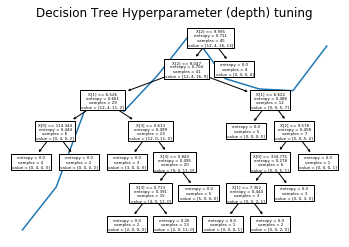

(0.9, 0.9, 6)

In [55]:
def tune_tree(verbose):
    # Hyperparameter Tuning
    x_rest, x_test, y_rest, y_test = get_data()

    depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    train_scores = []
    val_scores = []
    max_train = 0
    max_val = 0
    best_depth = 0
    splits = 10
    for depth in depths:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(x_rest)
        split_train_scores = []
        split_val_scores = []
        for train_index, val_index in kf.split(x_rest):
            x_train, x_val = x_rest[train_index], x_rest[val_index]
            y_train, y_val = y_rest[train_index], y_rest[val_index]
            train_score, val_score = run_tree(depth, x_train, y_train, x_val, y_val)
            split_train_scores.append(train_score)
            split_val_scores.append(val_score)
        train_score = sum(split_train_scores) / len(split_train_scores)
        val_score = sum(split_val_scores) / len(split_val_scores)
        train_scores.append(train_score)
        val_scores.append(val_score)
        if val_score > max_val:
            best_depth = depth
            max_val = val_score
        
    train_score, test_score = run_tree(best_depth, x_train, y_train, x_test, y_test)
    if verbose:
        print(train_score, test_score)
        print(f"Best max depth: {best_depth}")
        print(f"Best validation performance: {max_val}")
        print(f"Test performance: {test_score}")
        plt.plot(depths, val_scores)
        plt.title("Decision Tree Hyperparameter (depth) tuning")
        plt.show()
    return max_val, test_score, best_depth

tune_tree(verbose=True)

## Repeat the experiment multiple times

In [ ]:
# Initialize lists
log_vals = []
log_tests = []
log_params = []
svc_vals = []
svc_tests = []
svc_param1s = []
svc_param2s = []
tree_vals = []
tree_tests = []
tree_params = []

# Run expirement many times
max_repetitions = 100
for _ in range(max_repetitions):
    log_val, log_test, log_param = tune_log_reg(verbose=False)
    log_vals.append(log_val)
    log_tests.append(log_test)
    log_params.append(log_param)

    svc_val, svc_test, svc_param1, svc_param2 = tune_svc(verbose=False)
    svc_vals.append(svc_val)
    svc_tests.append(svc_test)
    svc_param1s.append(svc_param1)
    svc_param2s.append(svc_param2)

    tree_val, tree_test, tree_param = tune_tree(verbose=False)
    tree_vals.append(tree_val)
    tree_tests.append(tree_test)
    tree_params.append(tree_param)

# Calculate average
avg_log_vals = sum(log_vals) / len(log_vals)
avg_log_tests = sum(log_tests) / len(log_tests)
avg_log_params = sum(log_params) / len(log_params)

avg_svc_vals = sum(svc_vals) / len(svc_vals)
avg_svc_tests = sum(svc_tests) / len(svc_tests)
avg_svc_param1s = sum(svc_param1s) / len(svc_param1s)
avg_svc_param2s = sum(svc_param2s) / len(svc_param2s)

avg_tree_vals = sum(tree_vals) / len(tree_vals)
avg_tree_tests = sum(tree_tests) / len(tree_tests)
avg_tree_params = sum(tree_params) / len(tree_params)

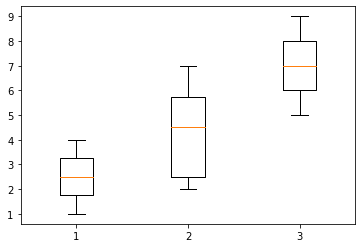

In [76]:
print("Logistic Regression")
print(f"Average Validation: {avg_log_vals}, Average Test: {avg_log_tests} Average C: {avg_log_params}")
print("SVC")
print(f"Average Validation: {avg_svc_vals}, Average Test: {avg_svc_tests} Average C: {avg_svc_param1s}, Average Gamma: {avg_svc_param2s}")
print("Decision Tree")
print(f"Average Validation: {avg_tree_vals}, Average Test: {avg_tree_tests}, Average Depth: {avg_tree_params}")

plt.boxplot([avg_log_tests, avg_svc_tests, avg_tree_tests])
plt.show()